In [1]:
import pandas as pd

### Columns encoding

In [130]:
df_mayor = pd.read_csv('data/data_mayoral.csv')

In [131]:
# Gender encoding
df_mayor['gender_est_rep'] = df_mayor['gender_est_rep'].map({'M': 1, 'F': 0})
df_mayor['gender_est_dem'] = df_mayor['gender_est_dem'].map({'M': 1, 'F': 0})

In [132]:
# State encoding
state_categories_df = pd.read_csv('data/state_categories.csv')

# Merge with df_mayor
df_mayor = df_mayor.merge(state_categories_df, on='state_abb', how="left")
df_mayor.rename(columns={"category": "state_category"}, inplace=True)
df_mayor.drop(columns=["state_abb"], inplace=True)

# Convert 'state_category' to one-hot encoding
df_mayor = pd.get_dummies(df_mayor, columns=['state_category'], prefix='state_category')
for col in df_mayor.filter(like='state_category').columns:
    df_mayor[col] = df_mayor[col].astype(int)

In [133]:
df_mayor.columns

Index(['geo_name', 'year', 'contest', 'fips', 'full_name_rep',
       'vote_share_rep', 'incumbent_rep', 'contributor.cfscore_rep',
       'prob_democrat_rep', 'gender_est_rep', 'race_est_rep', 'pid_est_rep',
       'full_name_dem', 'vote_share_dem', 'incumbent_dem',
       'contributor.cfscore_dem', 'prob_democrat_dem', 'gender_est_dem',
       'race_est_dem', 'pid_est_dem', 'percent_women', 'pres_pctD', 'total',
       'hispanic', 'white', 'black', 'asian', 'state_category_dem_state',
       'state_category_rep_state', 'state_category_swing_state'],
      dtype='object')

In [134]:
df_mayor["race_est_rep_white"] = df_mayor["race_est_rep"].apply(lambda x: 1 if x == "white" else 0)
df_mayor["race_est_dem_white"] = df_mayor["race_est_dem"].apply(lambda x: 1 if x == "white" else 0)

In [135]:
df_mayor.drop(columns = ["year","geo_name", "contest", "full_name_rep", "full_name_dem", "pid_est_rep", "race_est_rep", "race_est_dem", "pid_est_dem"], inplace = True)

In [157]:
df_mayor_reg = df_mayor.copy()
df_mayor_class = df_mayor.copy()
df_mayor_class["winner_dem"] = df_mayor_class.apply(lambda x: 1 if x["vote_share_dem"] >= x["vote_share_rep"] else 0, axis = 1)
df_mayor_class.drop(columns = ["vote_share_rep", "vote_share_dem"], inplace = True)
df_mayor_reg.drop(columns = ["vote_share_rep"], inplace = True)

In [137]:
df_mayor_class.columns

Index(['fips', 'incumbent_rep', 'contributor.cfscore_rep', 'prob_democrat_rep',
       'gender_est_rep', 'incumbent_dem', 'contributor.cfscore_dem',
       'prob_democrat_dem', 'gender_est_dem', 'percent_women', 'pres_pctD',
       'total', 'hispanic', 'white', 'black', 'asian',
       'state_category_dem_state', 'state_category_rep_state',
       'state_category_swing_state', 'race_est_rep_white',
       'race_est_dem_white', 'winner_dem'],
      dtype='object')

# Feature Selection

In [159]:
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

def feature_selection_slicer(X, selected_indices):
    return X.iloc[:, selected_indices]

# Feature Selection using Univariate Feature Selection (ANOVA F-test)
def univariate_feature_selection(X, y, k=3):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X, y)
    selected_features = selector.get_support(indices=True)
    return feature_selection_slicer(X, selected_features), selected_features

# Feature Selection using Feature Importance from RandomForest
def feature_importance_selection(X, y, num_features=3):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:num_features]
    return feature_selection_slicer(X, indices), indices

# Feature Selection using Recursive Feature Elimination (RFE)
def recursive_feature_elimination(X, y, num_features=3):
    model = RandomForestClassifier(random_state=42)
    selector = RFE(model, n_features_to_select=num_features, step=1)
    selector.fit(X, y)
    selected_features = selector.get_support(indices=True)
    return feature_selection_slicer(X, selected_features), selected_features

# Load dataset
X, y = df_mayor_class.drop(columns = ["winner_dem"]), df_mayor_class.winner_dem

# Apply feature selection
k = 16  # Number of features to select
X_uni, selected_uni = univariate_feature_selection(X, y, k=k)
X_importance, selected_importance = feature_importance_selection(X, y, num_features=k)
X_rfe, selected_rfe = recursive_feature_elimination(X, y, num_features=k)

# Print selected features for each method
print(f"Selected features (Univariate): {selected_uni}")
print(f"Selected features (Feature Importance): {selected_importance}")
print(f"Selected features (RFE): {selected_rfe}")

# aggregate scores from the three methods to get one list
scores = {}
for feat_selec_version in [selected_uni, selected_importance, selected_rfe]:
    for i in feat_selec_version:
        if i in scores:
            scores[i] = scores[i] + 1
        else:
            scores[i] = 1

keepers= sorted(scores, key=scores.get, reverse=True)[:15] 
class_cols = []
reg_cols = []
for i in range(len(X.columns)):
    if i in selected_rfe:
        class_cols.append(X.columns[i])
        reg_cols.append(X.columns[i])
class_cols.append("winner_dem")
reg_cols.append("vote_share_dem")

df_mayor_class = df_mayor_class[class_cols]
df_mayor_reg = df_mayor_reg[reg_cols]

Selected features (Univariate): [ 0  1  3  4  5  7  8  9 10 12 13 14 15 17 18 19]
Selected features (Feature Importance): [ 1 10  5 14 15 13 11  6  2 12  0  7  9  3  8 20]
Selected features (RFE): [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 18]


In [160]:
print(class_cols)

['fips', 'incumbent_rep', 'contributor.cfscore_rep', 'prob_democrat_rep', 'incumbent_dem', 'contributor.cfscore_dem', 'prob_democrat_dem', 'gender_est_dem', 'percent_women', 'pres_pctD', 'total', 'hispanic', 'white', 'black', 'asian', 'state_category_swing_state', 'winner_dem']


# Regression

In [161]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
X, y = df_mayor_reg.drop(columns = ["vote_share_dem"]), df_mayor_reg.vote_share_dem

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipelines for each model
pipelines = {
    "DecisionTree": Pipeline([
        ("clf", DecisionTreeRegressor(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostRegressor(random_state=42))
    ]),
    "MLPRegressor": Pipeline([
        ("scaler", StandardScaler()),  # Scaling is critical for MLP
        ("clf", MLPRegressor(max_iter=1000, random_state=42))
    ]),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),  # Scaling is critical for SVM
        ("clf", SVR())
    ]),
    "LinearRegression": Pipeline([
        ("clf", LinearRegression())
    ])
}

# Define hyperparameter grids for each model
param_grids = {
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.01, 0.1, 1]
    },
    "MLPRegressor": {
        "clf__hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "clf__activation": ["relu", "tanh"],
        "clf__alpha": [0.0001, 0.001, 0.01],
        "clf__learning_rate_init": [0.001, 0.01]
    },
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto"]
    },
    "LinearRegression": {
        # No hyperparameters to tune for standard LinearRegression
    }
}

# Perform grid search cross-validation for each model
best_estimators = {}
for model_name, pipeline in pipelines.items():
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(pipeline, param_grids.get(model_name, {}), cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validated score for {model_name} (neg MSE): {grid_search.best_score_:.4f}\n")

# Evaluate each model on the test set
for model_name, model in best_estimators.items():
    print(f"Evaluating {model_name} on the test set...")
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error for {model_name}: {mse:.4f}")
    print(f"R^2 Score for {model_name}: {r2:.4f}\n")


Performing Grid Search for DecisionTree...
Best parameters for DecisionTree: {'clf__max_depth': 5, 'clf__min_samples_split': 5}
Best cross-validated score for DecisionTree (neg MSE): -0.0197

Performing Grid Search for AdaBoost...
Best parameters for AdaBoost: {'clf__learning_rate': 0.1, 'clf__n_estimators': 100}
Best cross-validated score for AdaBoost (neg MSE): -0.0177

Performing Grid Search for MLPRegressor...
Best parameters for MLPRegressor: {'clf__activation': 'tanh', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (100,), 'clf__learning_rate_init': 0.01}
Best cross-validated score for MLPRegressor (neg MSE): -0.0203

Performing Grid Search for SVM...
Best parameters for SVM: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best cross-validated score for SVM (neg MSE): -0.0173

Performing Grid Search for LinearRegression...
Best parameters for LinearRegression: {}
Best cross-validated score for LinearRegression (neg MSE): -0.0174

Evaluating DecisionTree on the test s

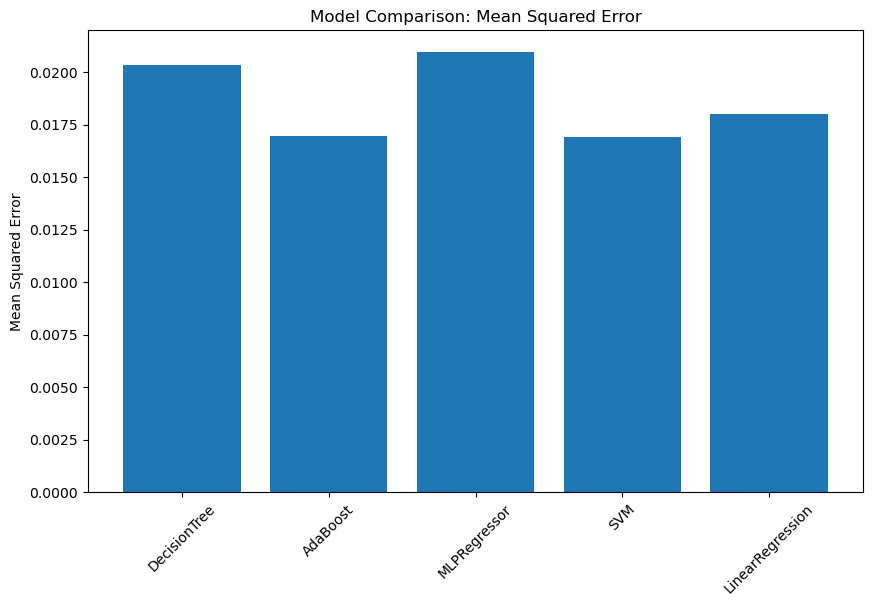

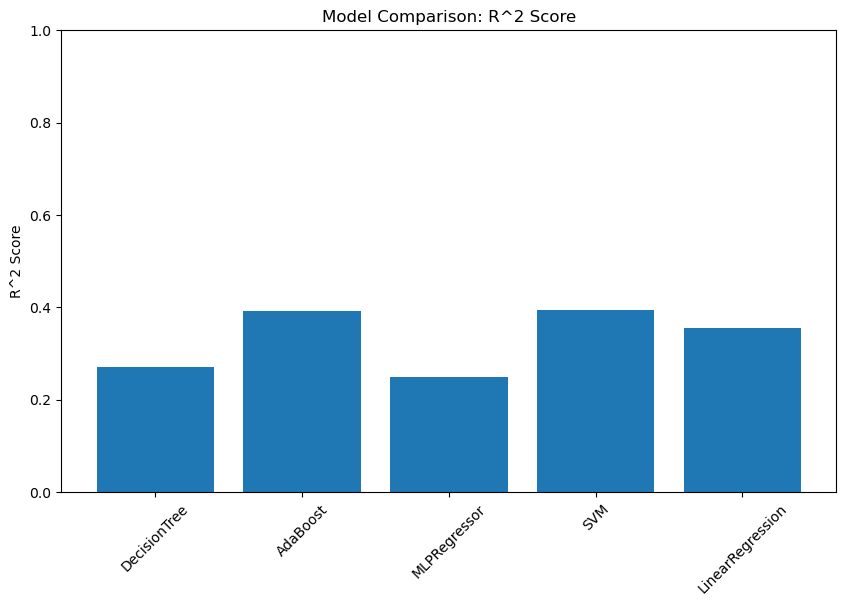

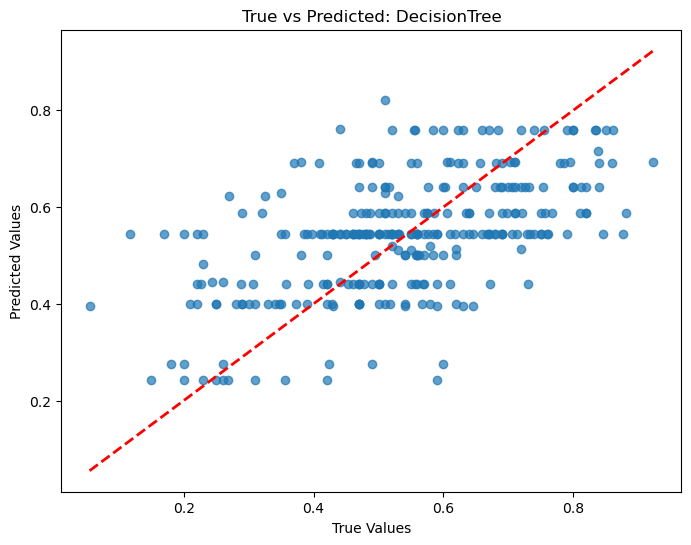

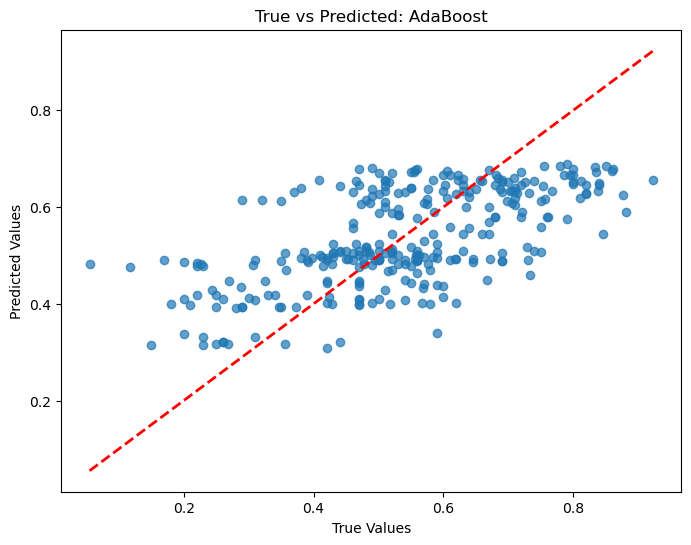

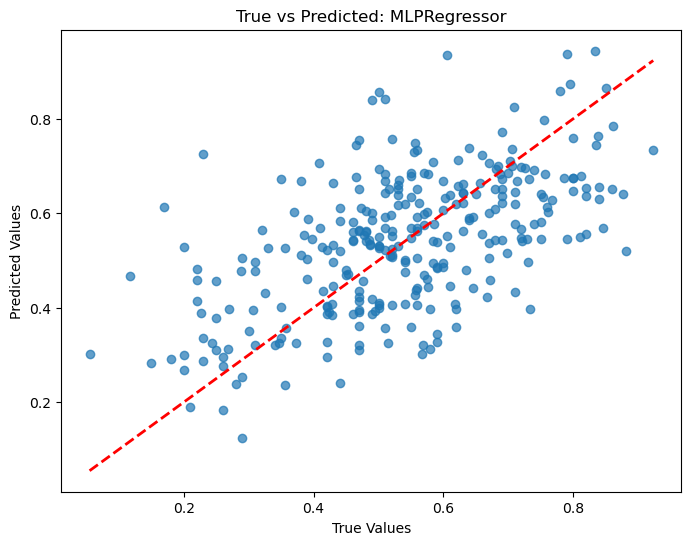

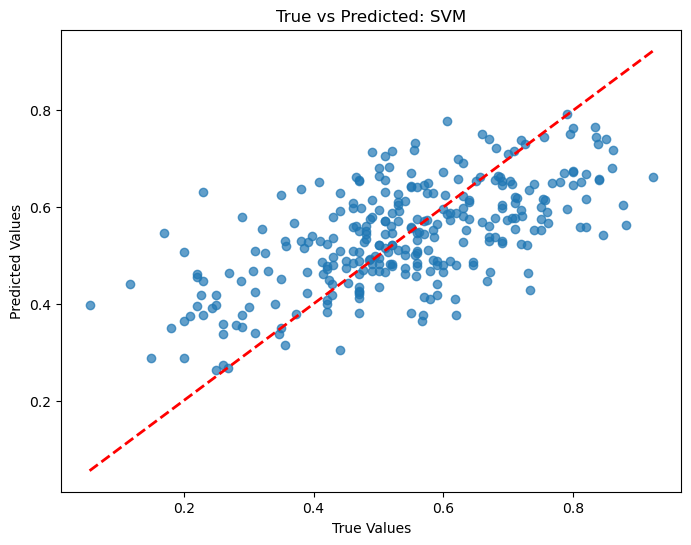

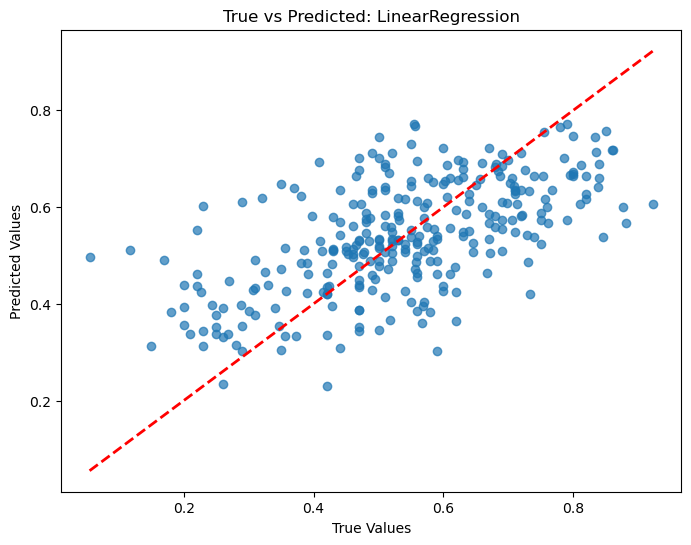

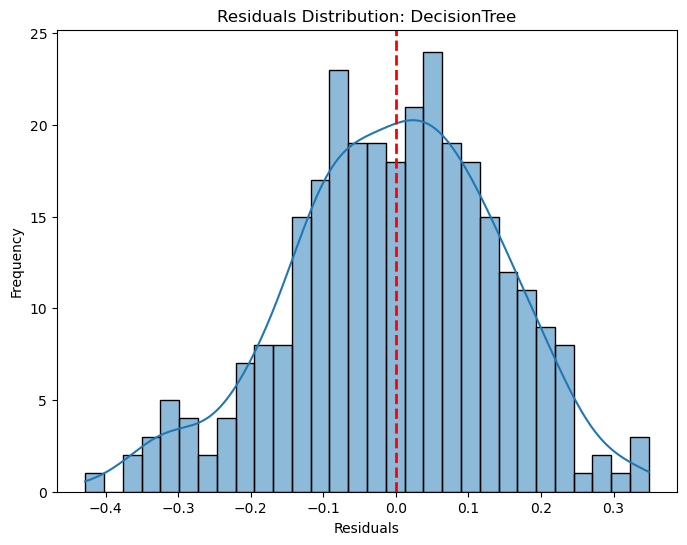

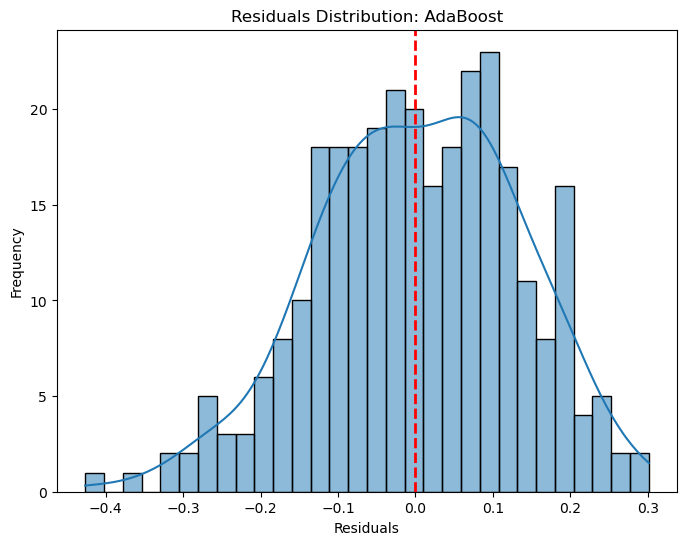

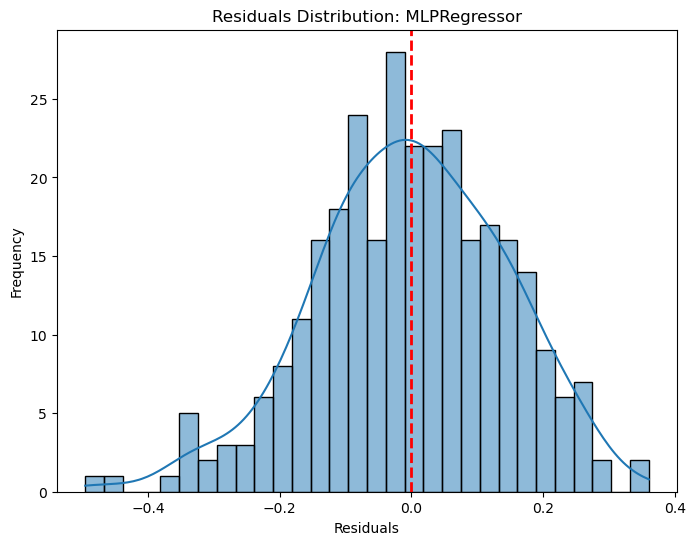

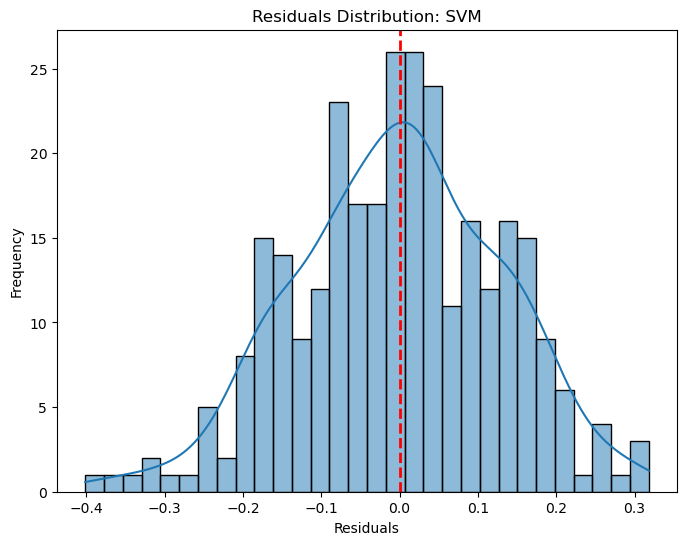

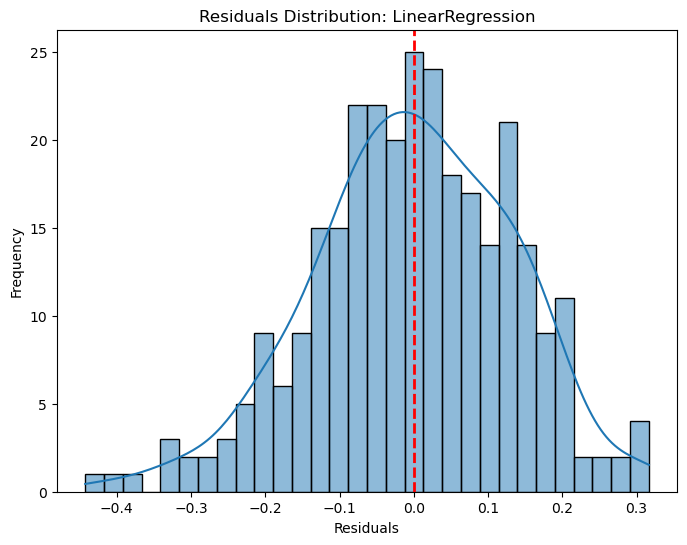

In [162]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Models results
regression_results = {}

for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    regression_results[model_name] = {
        "mse": mse,
        "r2": r2,
        "y_pred": y_pred,
    }

# Bar chart for MSE and R^2 scores
mse_values = [result["mse"] for result in regression_results.values()]
r2_values = [result["r2"] for result in regression_results.values()]
model_names = list(regression_results.keys())

# MSE Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, mse_values)
plt.ylabel("Mean Squared Error")
plt.title("Model Comparison: Mean Squared Error")
plt.xticks(rotation=45)
plt.show()

# R^2 Score Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(model_names, r2_values)
plt.ylabel("R^2 Score")
plt.title("Model Comparison: R^2 Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# Scatter plots: True vs Predicted values
for model_name, result in regression_results.items():
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, result["y_pred"], alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2)
    plt.title(f"True vs Predicted: {model_name}")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.show()

# Residual plots
for model_name, result in regression_results.items():
    residuals = y_test - result["y_pred"]
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True, bins=30)
    plt.title(f"Residuals Distribution: {model_name}")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.axvline(0, color="red", linestyle="--", linewidth=2)
    plt.show()


# Classification

In [163]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Custom class to adapt LinearRegression for classification using predict_proba
class LinearRegressionClassifier:
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y_one_hot = np.zeros((y.size, len(self.classes_)))
        for i, c in enumerate(self.classes_):
            y_one_hot[:, i] = (y == c).astype(float)
        self.model.fit(X, y_one_hot)
        return self

    def predict(self, X):
        probas = self.predict_proba(X)
        return self.classes_[np.argmax(probas, axis=1)]

    def predict_proba(self, X):
        raw_scores = self.model.predict(X)
        exp_scores = np.exp(raw_scores - np.max(raw_scores, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

# Load dataset
X, y = df_mayor_class.drop(columns = ["winner_dem"]), df_mayor_class.winner_dem

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define pipelines for each model
pipelines = {
    "DecisionTree": Pipeline([
        ("clf", DecisionTreeClassifier(random_state=42))
    ]),
    "AdaBoost": Pipeline([
        ("clf", AdaBoostClassifier(random_state=42))
    ]),
    "MLPClassifier": Pipeline([
        ("scaler", StandardScaler()),  # Scaling is critical for MLP
        ("clf", MLPClassifier(max_iter=1000, random_state=42))
    ]),
    "SVM": Pipeline([
        ("scaler", StandardScaler()),  # Scaling is critical for SVM
        ("clf", SVC(probability=True))
    ]),
    "LinearRegressionClassifier": Pipeline([
        ("scaler", StandardScaler()),  # Scaling helps with numerical stability
        ("clf", LinearRegressionClassifier())
    ])
}

# Define hyperparameter grids for each model
param_grids = {
    "DecisionTree": {
        "clf__max_depth": [None, 5, 10, 20],
        "clf__min_samples_split": [2, 5, 10]
    },
    "AdaBoost": {
        "clf__n_estimators": [50, 100, 200],
        "clf__learning_rate": [0.01, 0.1, 1]
    },
    "MLPClassifier": {
        "clf__hidden_layer_sizes": [(50,), (100,), (50, 50)],
        "clf__activation": ["relu", "tanh"],
        "clf__alpha": [0.0001, 0.001, 0.01],
        "clf__learning_rate_init": [0.001, 0.01]
    },
    "SVM": {
        "clf__C": [0.1, 1, 10],
        "clf__kernel": ["linear", "rbf"],
        "clf__gamma": ["scale", "auto"]
    },
    "LinearRegressionClassifier": {
        # No hyperparameters to tune for the custom LinearRegressionClassifier
    }
}

# Perform grid search cross-validation for each model
best_estimators = {}
for model_name, pipeline in pipelines.items():
    print(f"Performing Grid Search for {model_name}...")
    grid_search = GridSearchCV(pipeline, param_grids.get(model_name, {}), cv=5, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validated accuracy for {model_name}: {grid_search.best_score_:.4f}\n")

# Evaluate each model on the test set
for model_name, model in best_estimators.items():
    print(f"Evaluating {model_name} on the test set...")
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    print(f"Accuracy for {model_name}: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print(f"Predicted probabilities (first 5 samples): \ren{y_proba[:5]}\n")


Performing Grid Search for DecisionTree...
Best parameters for DecisionTree: {'clf__max_depth': 5, 'clf__min_samples_split': 5}
Best cross-validated accuracy for DecisionTree: 0.6999

Performing Grid Search for AdaBoost...
Best parameters for AdaBoost: {'clf__learning_rate': 0.1, 'clf__n_estimators': 200}
Best cross-validated accuracy for AdaBoost: 0.7527

Performing Grid Search for MLPClassifier...


/Users/keesvanhemmen/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/keesvanhemmen/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/keesvanhemmen/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/keesvanhemmen/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters for MLPClassifier: {'clf__activation': 'relu', 'clf__alpha': 0.01, 'clf__hidden_layer_sizes': (50,), 'clf__learning_rate_init': 0.001}
Best cross-validated accuracy for MLPClassifier: 0.7309

Performing Grid Search for SVM...
Best parameters for SVM: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
Best cross-validated accuracy for SVM: 0.7485

Performing Grid Search for LinearRegressionClassifier...
Best parameters for LinearRegressionClassifier: {}
Best cross-validated accuracy for LinearRegressionClassifier: 0.7502

Evaluating DecisionTree on the test set...
Accuracy for DecisionTree: 0.6856
              precision    recall  f1-score   support

           0       0.57      0.68      0.62       114
           1       0.78      0.69      0.73       185

    accuracy                           0.69       299
   macro avg       0.68      0.69      0.68       299
weighted avg       0.70      0.69      0.69       299

Predicted probabilities (first 5 samples)

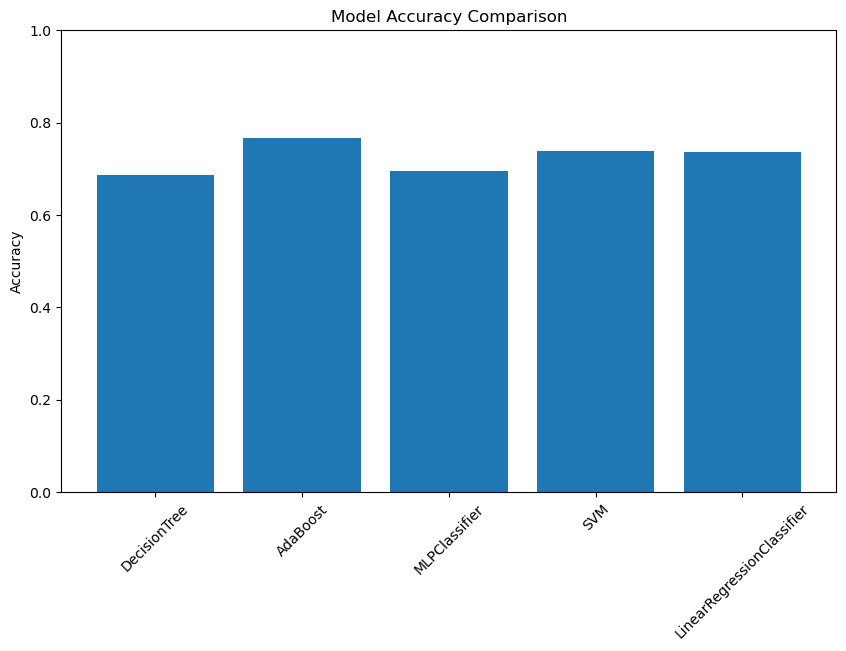

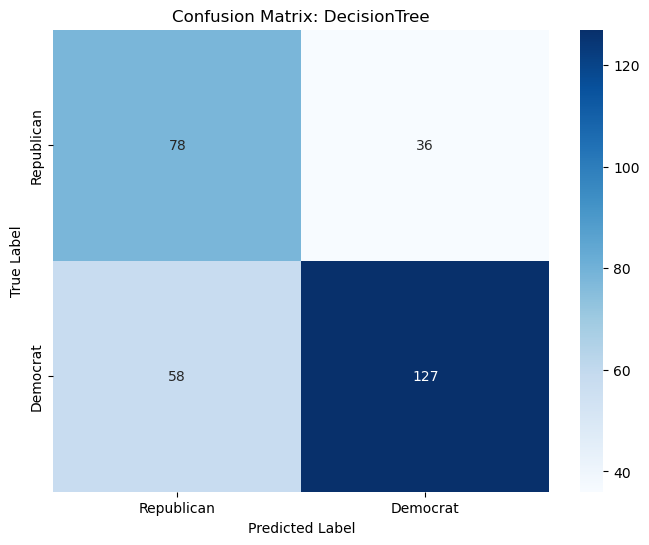

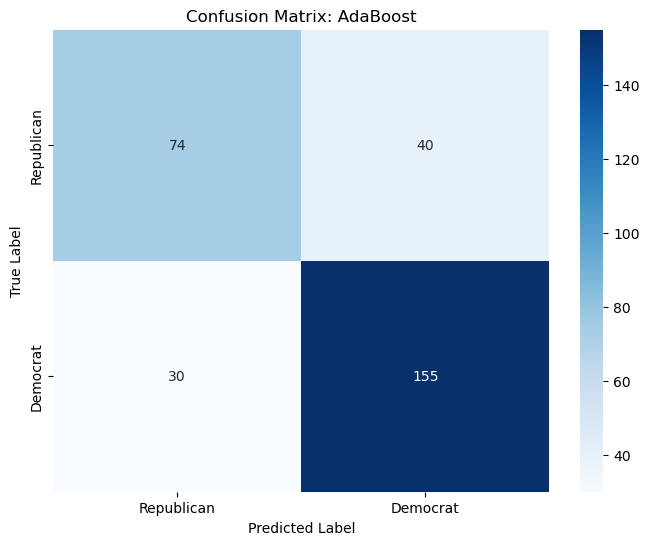

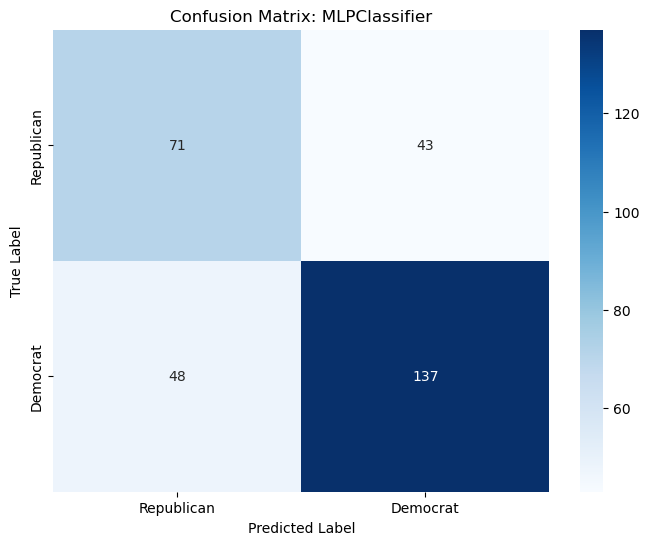

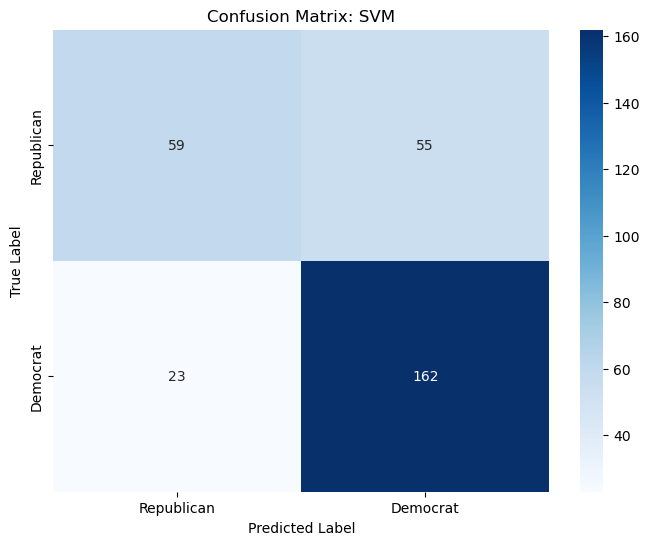

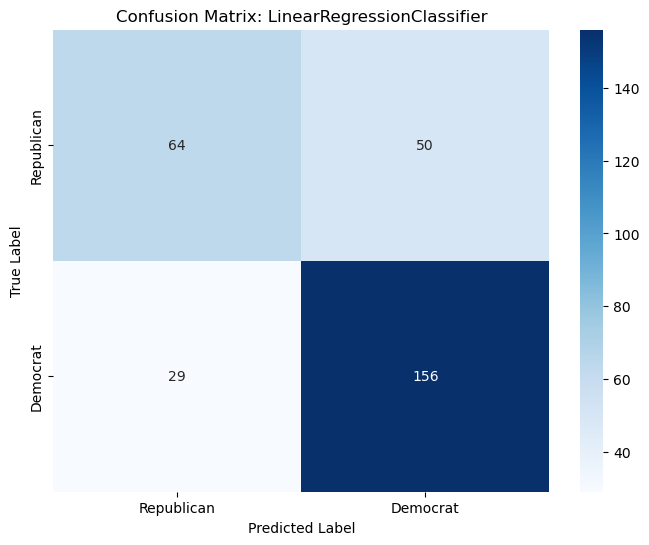

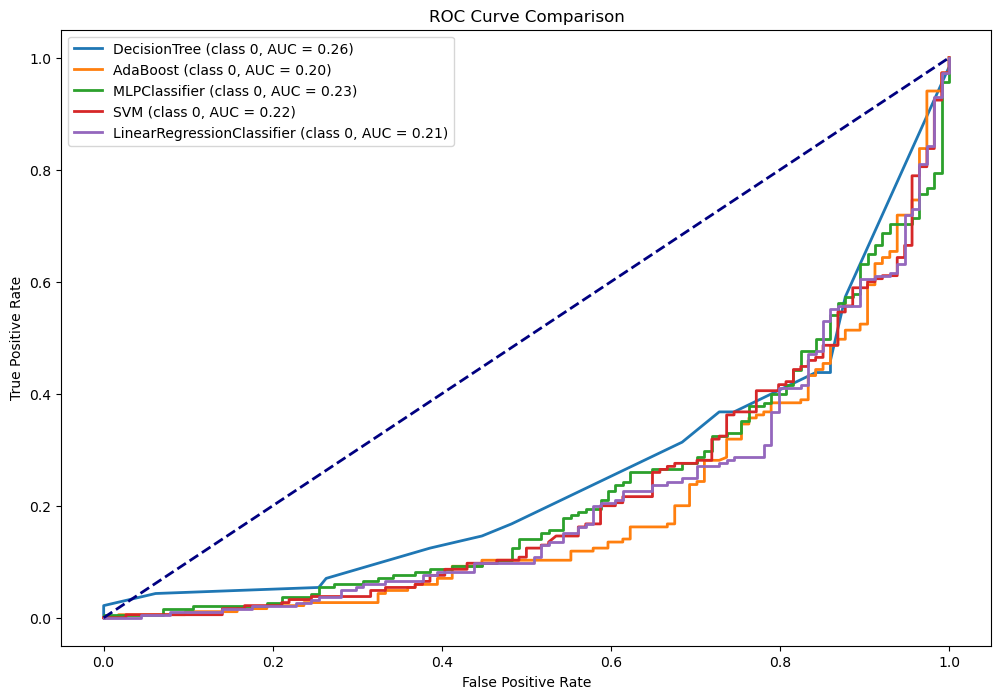

In [164]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import RocCurveDisplay
import seaborn as sns

# Evaluate models and collect results
model_results = {}
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

for model_name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None
    accuracy = accuracy_score(y_test, y_pred)
    model_results[model_name] = {
        "accuracy": accuracy,
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "y_pred": y_pred,
        "y_proba": y_proba,
    }

# Plot accuracy comparison
plt.figure(figsize=(10, 6))
accuracies = [result["accuracy"] for result in model_results.values()]
model_names = list(model_results.keys())
plt.bar(model_names, accuracies)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()

# Plot confusion matrices
for model_name, result in model_results.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        result["confusion_matrix"],
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["Republican", "Democrat"],
        yticklabels=["Republican","Democrat"],
    )
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Plot ROC curves for models with predict_proba
plt.figure(figsize=(12, 8))
for model_name, result in model_results.items():
    if result["y_proba"] is not None:
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_binarized[:, i], result["y_proba"][:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(
                fpr,
                tpr,
                lw=2,
                label=f"{model_name} (class {i}, AUC = {roc_auc:.2f})",
            )

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="best")
plt.show()
